In [1]:
import itertools

import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import lab.metrics
import lab.analytics

In [2]:
def load_classifier_prediction(classifier: str, factor: str, rep: int):
    return pd.read_csv(
        f"../../results/ml-eval/predictions/{factor}/{classifier}-{rep}.csv",
        header=0
    )

def load_results():
    combinations = [
        (classifier, factor, rep) for classifier in ["kfp", "dfnet"]
        for factor in [
            "sim-front-dataset-filtered", "front-dataset-filtered", "sim-tamaraw-dataset-filtered", "tamaraw-dataset-filtered",
            "sim-front-dataset", "front-dataset", "sim-tamaraw-dataset", "tamaraw-dataset", "control-dataset",
            "control-dataset-filtered"
        ]
        for rep in range(1)
    ]
        
    return (pd.concat([
        load_classifier_prediction(classifier, factor, rep)
        for (classifier, factor, rep) in combinations
    ], keys=combinations, names=["classifier", "factor", "run", "sample"])
            .fillna(0)
            .rename(columns=lambda c: int(c) if c != "y_true" else c)
            .drop(columns=[-1]))


data = load_results()
data

y_true             0  \
classifier factor                     run sample                         
kfp        sim-front-dataset-filtered 0   0          0.0  1.000000e+00   
                                          1          0.0  1.000000e+00   
                                          2          0.0  1.000000e+00   
                                          3          0.0  1.000000e+00   
                                          4          0.0  1.000000e+00   
...                                                  ...           ...   
dfnet      control-dataset-filtered   0   1983      -1.0  3.439505e-12   
                                          1984      -1.0  3.130928e-04   
                                          1985      -1.0  5.868364e-13   
                                          1986      -1.0  4.125728e-09   
                                          1987      -1.0  6.743740e-08   

                                                             1             2  \
classifier factor                     run sample                               
kfp        sim-front-dataset-filtered 0   0       0.000000e+00  0.000000e+00   
                                          1       0.000000e+00  0.000000e+00   
                                          2       0.000000e+00  0.000000e+00   
                                          3       0.000000e+00  0.000000e+00   
                                          4       0.000000e+00  0.000000e+00   
...                                                        ...           ...   
dfnet      control-dataset-filtered   0   1983    2.314910e-10  5.942796e-12   
                                          1984    2.080098e-06  1.728383e-07   
                                          1985    2.528193e-16  2.958549e-12   
                                          1986    3.577300e-14  6.355522e-12   
                                          1987    1.462652e-05  4.872608e-08   

                                                             3             4  \
classifier factor                     run sample                               
kfp        sim-front-dataset-filtered 0   0       0.000000e+00  0.000000e+00   
                                          1       0.000000e+00  0.000000e+00   
                                          2       0.000000e+00  0.000000e+00   
                                          3       0.000000e+00  0.000000e+00   
                                          4       0.000000e+00  0.000000e+00   
...                                                        ...           ...   
dfnet      control-dataset-filtered   0   1983    1.819504e-10  9.927966e-12   
                                          1984    2.724320e-05  9.673993e-07   
                                          1985    8.963285e-17  1.129637e-11   
                                          1986    1.820020e-11  6.853793e-11   
                                          1987    3.539348e-04  1.879724e-06   

                                                             5             6  \
classifier factor                     run sample                               
kfp        sim-front-dataset-filtered 0   0       0.000000e+00  0.000000e+00   
                                          1       0.000000e+00  0.000000e+00   
                                          2       0.000000e+00  0.000000e+00   
                                          3       0.000000e+00  0.000000e+00   
                                          4       0.000000e+00  0.000000e+00   
...                                                        ...           ...   
dfnet      control-dataset-filtered   0   1983    8.765369e-14  6.675117e-12   
                                          1984    9.757564e-08  3.472665e-04   
                                          1985    5.672454e-12  2.449907e-13   
                                          1986    1.132706e-08  4.830406e-09   
                                          198

In [3]:
def precision_recall_curve(df):
    return pd.DataFrame(lab.analytics.rprecision_recall_curve(
        df["y_true"], df.drop("y_true", axis=1), ratio=20
    )._asdict())

In [4]:
def plot_pr_curve(data):
    data = (data
            .transform(lambda x: x*100)
            .rename({"dfnet": "DF", "varcnn": "Var-CNN", "p1fp": "$p$-FP(C)", "kfp": "$k$-FP"}, axis=0)
            .rename({"precision": "$\pi_{20}$ (\%)", "recall": "Recall (\%)"}, axis=1)
            .reset_index())
    display(data)

    with plt.style.context([]):#"./mpl-style/pr-curve.mplstyle", "./mpl-style/pets.mplstyle", {"text.usetex": True}]):
        grid = sns.relplot(
            data=data, x="Recall (\%)", y="$\pi_{20}$ (\%)", hue="factor",
            style="factor", col="classifier", kind="line", 
            facet_kws=dict(legend_out=True, despine=False,
                           gridspec_kws=dict(wspace=.1)),
            palette="binary", legend=True
        )
        grid.set_titles(col_template="{col_name}")
        
        for i, ax in enumerate(np.ravel(grid.axes)):
            # if i == 0:
            #     ax.legend(labels=["Unmon.", "Control", "Both"])
            ax.set_xticks([0, 50, 100])
            ax.set_yticks([0, 50, 100])
            ax.xaxis.get_major_formatter()._usetex = False
            ax.yaxis.get_major_formatter()._usetex = False
        
    return grid

In [11]:
data2 = (data.groupby(["classifier", "factor"])
             .apply(precision_recall_curve)
             .set_index("thresholds", append=True))
data2
            

precision    recall
classifier factor                     thresholds                     
dfnet      control-dataset          0 0.000        0.045286  0.951000
                                    1 0.001        0.075124  0.951000
                                    2 0.002        0.082131  0.951000
                                    3 0.003        0.087416  0.951000
                                    4 0.004        0.090926  0.951000
...                                                     ...       ...
kfp        tamaraw-dataset-filtered 2 0.333        0.271849  0.928571
                                    3 0.500        0.308877  0.919388
                                    4 0.667        0.399029  0.893878
                                    5 0.833        0.399029  0.893878
                                    6 1.000        0.471122  0.865306

[3383 rows x 2 columns]

In [17]:
plot_data = data2.copy()
factors = plot_data.index.get_level_values("factor")
plot_data["is_filtered"] = factors.str.contains("filtered")
plot_data["is_simulated"] = factors.str.contains("sim_")
plot_data["defence"] = ""
plot_data.loc[factors.str.contains("tamaraw"), "defence"] = "tamaraw"
plot_data.loc[factors.str.contains("front"), "defence"] = "front"
plot_data.loc[factors.str.contains("control"), "defence"] = "control"
plot_data = plot_data.reset_index()
plot_data["factor"] = plot_data["factor"].replace({
    "control-dataset": "control",
    "control-dataset-filtered": "control",
    "front-dataset": "front",
    "front-dataset-filtered": "front",
    "sim-front-dataset": "sim-front",
    "sim-front-dataset-filtered": "sim-front",
    "tamaraw-dataset": "tamaraw",
    "tamaraw-dataset-filtered": "tamaraw",
    "sim-tamaraw-dataset": "sim-tamaraw",
    "sim-tamaraw-dataset-filtered": "sim-tamaraw",
})
plot_data



,classifier,factor,level_2,thresholds,precision,recall,is_filtered,is_simulated,defence
0,dfnet,control,0,0.000,0.045286,0.951000,False,False,control
1,dfnet,control,1,0.001,0.075124,0.951000,False,False,control
2,dfnet,control,2,0.002,0.082131,0.951000,False,False,control
3,dfnet,control,3,0.003,0.087416,0.951000,False,False,control
4,dfnet,control,4,0.004,0.090926,0.951000,False,False,control
...,...,...,...,...,...,...,...,...,...
3378,kfp,tamaraw,2,0.333,0.271849,0.928571,True,False,tamaraw
3379,kfp,tamaraw,3,0.500,0.308877,0.919388,True,False,tamaraw
3380,kfp,tamaraw,4,0.667,0.399029,0.893878,True,False,tamaraw
3381,kfp,tamaraw,5,0.833,0.399029,0.893878,True,False,tamaraw


,classifier,factor,level_2,thresholds,precision,recall,is_filtered,is_simulated,defence
0,dfnet,control,0,0.000,0.045286,0.951000,False,False,control
1,dfnet,control,1,0.001,0.075124,0.951000,False,False,control
2,dfnet,control,2,0.002,0.082131,0.951000,False,False,control
3,dfnet,control,3,0.003,0.087416,0.951000,False,False,control
4,dfnet,control,4,0.004,0.090926,0.951000,False,False,control
...,...,...,...,...,...,...,...,...,...
3378,kfp,tamaraw,2,0.333,0.271849,0.928571,True,False,tamaraw
3379,kfp,tamaraw,3,0.500,0.308877,0.919388,True,False,tamaraw
3380,kfp,tamaraw,4,0.667,0.399029,0.893878,True,False,tamaraw
3381,kfp,tamaraw,5,0.833,0.399029,0.893878,True,False,tamaraw


/home/jsmith/Projects/quic-client-defence/code/qcd-experiments/env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-client-defence/code/qcd-experiments/env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-client-defence/code/qcd-experiments/env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-client-defence/code/qcd-experiments/env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible

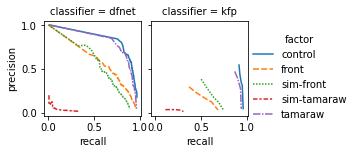

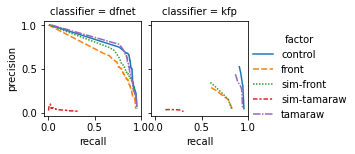

In [18]:
display(plot_data)

sns.relplot(
    data=plot_data[plot_data["is_filtered"] == True], x="recall", y="precision", col="classifier", hue="factor", style="factor",
    facet_kws=dict(legend_out=True, despine=False, gridspec_kws=dict(wspace=.1)),
    legend=True, kind="line", height=1.75, aspect=1
).savefig("../../results/plots/ml-eval-prcurve-filtered.png", bbox_inches="tight", dpi=150)

sns.relplot(
    data=plot_data[plot_data["is_filtered"] == False], x="recall", y="precision", col="classifier", hue="factor", style="factor",
    facet_kws=dict(legend_out=True, despine=False, gridspec_kws=dict(wspace=.1)),
    legend=True, kind="line", height=1.75, aspect=1
).savefig("../../results/plots/ml-eval-prcurve-unfiltered.png", bbox_inches="tight", dpi=150)